In [270]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


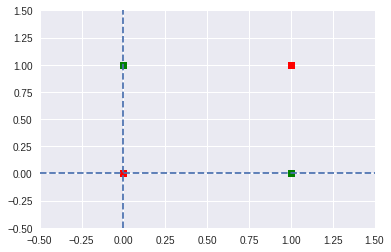

In [271]:
# hint: olvasd oszlopvektorként
# 1,0 és 0,1
true_x = [1,0] # true értékek x-e
true_y = [0,1] # true értékek y-a
# 0,0 és 1,1
false_x = [0,1]
false_y = [0,1]

plot1 = plt.plot(true_x, true_y, 'gs')
plot2 = plt.plot(false_x, false_y, 'rs')

plt.xlim(-0.5,1.5)
plt.ylim(-0.5,1.5)
plt.grid(True)

plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')



In [0]:
import numpy as np
from sklearn import preprocessing
import copy

In [0]:
%matplotlib inline

In [0]:
def a(x):
  return 1 / (1 + np.exp(-x))

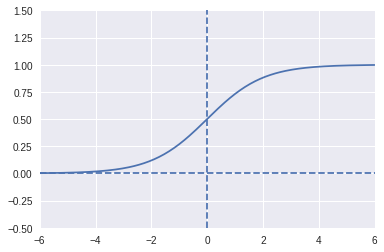

In [275]:
sX = np.linspace(-6,6,200)
plt.xlim(-6,6)
plt.ylim(-0.5, 1.5)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(sX,a(sX))

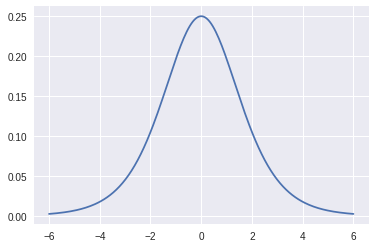

In [276]:
def d(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
plt.plot(sX,d(sX))

In [0]:
class MLP:
  def __init__(self, *args):
    np.random.seed(0)
    self.shape = args
    n = len(args)
    self.layers = []
    self.layers.append(np.ones(self.shape[0]+1))
    for i in range(1,n):
      self.layers.append(np.ones(self.shape[i]))
    self.weights = []
    for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
    self.dw = [0,]*len(self.weights)
    self.reset()
 
  def reset(self):
    for i in range(len(self.weights)):
        # véletlen számok [0,1) tartományban 
        Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
        # átskálázzuk a súlyokat -1..1 tartományba
        self.weights[i][...] = (2*Z-1)*1
        
 
  def forward(self, data):
    self.layers[0][0:-1] = data
    for i in range(1, len(self.shape)):
      self.layers[i][...] = a(np.dot(self.layers[i-1], self.weights[i-1]))
    return self.layers[-1]
  
  def backward(self, target, learningrate = 0.1, momentum = 0.1):
    deltas = []
    error = -(target-self.layers[-1])
    delta = np.multiply(error,d(np.dot(self.layers[-2],self.weights[-1])))
    deltas.append(delta)
    for i in range(len(self.shape)-2,0,-1):
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta=np.dot(deltas[0],self.weights[i].T)*d(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        # Súlyok módosítása
    for i in range(len(self.weights)):
        layer = np.atleast_2d(self.layers[i])
        delta = np.atleast_2d(deltas[i])
        # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
        dw = -learningrate*np.dot(layer.T,delta) + momentum*self.dw[i]
        # súlyok módosítása
        self.weights[i] += dw 
        '''
        # "hibás", de működő kód
        dw = np.dot(layer.T,delta)
        self.weights[i] -= lrate*dw - momentum*self.dw[i]  
        '''
        # a súlymódosítás eltárolása
        self.dw[i] = dw

    # Visszatérés a hibával
    return (error**2).sum()


In [0]:
def learn(network,samples, valid_split, test_split, epochs=5000, lrate=0.01, momentum=0.9, patience=10):
        train_err_list = []
        valid_err_list = []
        time_list = []
        endepoch = 0
        start = time.time()
        # train-validation-test minták különválasztása
        samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
        samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        samples_test  = samples[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(samples_train['input'])
        samples_train['input'] = scaler.transform(samples_train['input'])
        samples_valid['input'] = scaler.transform(samples_valid['input'])
        samples_test['input'] = scaler.transform(samples_test['input'])    
    
        # keverés
        np.random.shuffle(samples_train)
        np.random.shuffle(samples_valid)
        np.random.shuffle(samples_test)
    
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(samples_train.size):
                network.forward( samples_train['input'][k] )
                train_err += network.backward( samples_train['output'][k], lrate, momentum )
            train_err /= samples_train.size

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(samples_valid.size)
            for k in range(samples_valid.size):
                o_valid[k] = network.forward(samples_valid['input'][k])
                valid_err += (o_valid[k]-samples_valid['output'][k])**2
            valid_err /= samples_valid.size

            # Legjobb modell elmentése és early stopping
            if valid_err < best_valid_err:
                best_valid_err = np.round(valid_err,3)
                es_counter = 0
                best_model = copy.copy(network)
                # print("New best model found")
            else:
                es_counter += 1

            # print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))
            train_err_list.append(train_err)
            valid_err_list.append(valid_err)
            time_list.append(time.time()-start)
            if i > 30:
              if es_counter > patience:
                  endepoch = i
                  network=best_model
                  stop = time.time()
                  break
            
        # Tesztelési fázis
        vstart = time.time()
        test_err = 0
        o_test = np.zeros(samples_test.size)
        for k in range(samples_test.size):
            o_test[k] = network.forward(samples_test['input'][k])
            test_err += (o_test[k]-samples_test['output'][k])**2
            #print(k, samples_test['input'][k], '%.2f' % o_test[k], \
            #      ' (elvart eredmeny: %.2f)' % samples_test['output'][k])
        test_err /= samples_test.size
        vstop = time.time()
        
        print("Model: ", network.shape)
        plt.figure(1, figsize=(16, 5))
        plt.subplot(121)
        plt.xlim(0,300)
        plt.plot(train_err_list, 'red')
        plt.plot(valid_err_list, 'green')
        plt.xlabel('Error graph by epoch')
        plt.subplot(122)
        plt.xlim(0,4.0)
        plt.plot(time_list,train_err_list, 'red')
        plt.plot(time_list,valid_err_list, 'green')
        plt.xlabel('Error graph by time')
        
        #plt.scatter(samples_test['input'][:,0], samples_test['input'][:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)
        plt.show()
        print("Epoch: %d - Train error: %f - Test error: %f - Learn time: %f" % (endepoch, train_err_list[-1], test_err, (stop-start)))

In [0]:
def learn_dec_momentum(network,samples, valid_split, test_split, epochs=5000, lrate=0.01, momentum=0.9, patience=10):
        train_err_list = []
        valid_err_list = []
        time_list = []
        endepoch = 0
        es_started = True
        start = time.time()
        # train-validation-test minták különválasztása
        samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
        samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        samples_test  = samples[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(samples_train['input'])
        samples_train['input'] = scaler.transform(samples_train['input'])
        samples_valid['input'] = scaler.transform(samples_valid['input'])
        samples_test['input'] = scaler.transform(samples_test['input'])    
    
        # keverés
        np.random.shuffle(samples_train)
        np.random.shuffle(samples_valid)
        np.random.shuffle(samples_test)
    
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(samples_train.size):
                network.forward( samples_train['input'][k] )
                train_err += network.backward( samples_train['output'][k], lrate, momentum )
            train_err /= samples_train.size

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(samples_valid.size)
            for k in range(samples_valid.size):
                o_valid[k] = network.forward(samples_valid['input'][k])
                valid_err += (o_valid[k]-samples_valid['output'][k])**2
            valid_err /= samples_valid.size

            # Legjobb modell elmentése és early stopping
            if valid_err < best_valid_err:
                best_valid_err = np.round(valid_err,3)
                es_counter = 0
                es_started = True
                best_model = copy.copy(network)
                # print("New best model found")
            else:
                es_counter += 1

            # print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))
            train_err_list.append(train_err)
            valid_err_list.append(valid_err)
            time_list.append(time.time()-start)
            if i > 30:
              if es_counter > (patience/2):
                if es_started:
                  es_started = False
                  momentum = momentum * 0.5
                  print("momentum %f", momentum)
              if es_counter > patience:
                  endepoch = i
                  network=best_model
                  stop = time.time()
                  break
            
        # Tesztelési fázis
        vstart = time.time()
        test_err = 0
        o_test = np.zeros(samples_test.size)
        for k in range(samples_test.size):
            o_test[k] = network.forward(samples_test['input'][k])
            test_err += (o_test[k]-samples_test['output'][k])**2
            #print(k, samples_test['input'][k], '%.2f' % o_test[k], \
            #      ' (elvart eredmeny: %.2f)' % samples_test['output'][k])
        test_err /= samples_test.size
        vstop = time.time()
        
        print("Model: ", network.shape)
        plt.figure(1, figsize=(16, 5))
        plt.subplot(121)
        plt.xlim(0,300)
        plt.plot(train_err_list, 'red')
        plt.plot(valid_err_list, 'green')
        plt.xlabel('Error graph by epoch')
        plt.subplot(122)
        plt.xlim(0,4.0)
        plt.plot(time_list,train_err_list, 'red')
        plt.plot(time_list,valid_err_list, 'green')
        plt.xlabel('Error graph by time')
        
        #plt.scatter(samples_test['input'][:,0], samples_test['input'][:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)
        plt.show()
        print("Epoch: %d - Train error: %f - Test error: %f - Learn time: %f" % (endepoch, train_err_list[-1], test_err, (stop-start)))

In [0]:
def learn_double_lr(network,samples, valid_split, test_split, epochs=5000, lrate=0.01, momentum=0.9, patience=10):
        train_err_list = []
        valid_err_list = []
        time_list = []
        endepoch = 0
        es_started = True
        start = time.time()
        # train-validation-test minták különválasztása
        samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
        samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        samples_test  = samples[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(samples_train['input'])
        samples_train['input'] = scaler.transform(samples_train['input'])
        samples_valid['input'] = scaler.transform(samples_valid['input'])
        samples_test['input'] = scaler.transform(samples_test['input'])    
    
        # keverés
        np.random.shuffle(samples_train)
        np.random.shuffle(samples_valid)
        np.random.shuffle(samples_test)
    
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).
            train_err = 0
            for k in range(samples_train.size):
                network.forward( samples_train['input'][k] )
                train_err += network.backward( samples_train['output'][k], lrate, momentum )
            train_err /= samples_train.size

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(samples_valid.size)
            for k in range(samples_valid.size):
                o_valid[k] = network.forward(samples_valid['input'][k])
                valid_err += (o_valid[k]-samples_valid['output'][k])**2
            valid_err /= samples_valid.size

            # Legjobb modell elmentése és early stopping
            if valid_err < best_valid_err:
                best_valid_err = np.round(valid_err,3)
                es_counter = 0
                es_started = True
                best_model = copy.copy(network)
                # print("New best model found")
            else:
                es_counter += 1

            # print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))
            train_err_list.append(train_err)
            valid_err_list.append(valid_err)
            time_list.append(time.time()-start)
            if i > 30:
              if es_counter > (patience * 0.5):
                if es_started:
                  es_started = False
                  lrate = lrate * 2.5
                  print("lrate%f" % lrate)
              if es_counter > patience:
                  endepoch = i
                  network=best_model
                  stop = time.time()
                  break
            
        # Tesztelési fázis
        vstart = time.time()
        test_err = 0
        o_test = np.zeros(samples_test.size)
        for k in range(samples_test.size):
            o_test[k] = network.forward(samples_test['input'][k])
            test_err += (o_test[k]-samples_test['output'][k])**2
            #print(k, samples_test['input'][k], '%.2f' % o_test[k], \
            #      ' (elvart eredmeny: %.2f)' % samples_test['output'][k])
        test_err /= samples_test.size
        vstop = time.time()
        
        print("Model: ", network.shape)
        plt.figure(1, figsize=(16, 5))
        plt.subplot(121)
        plt.xlim(0,300)
        plt.plot(train_err_list, 'red')
        plt.plot(valid_err_list, 'green')
        plt.xlabel('Error graph by epoch')
        plt.subplot(122)
        plt.xlim(0,4.0)
        plt.plot(time_list,train_err_list, 'red')
        plt.plot(time_list,valid_err_list, 'green')
        plt.xlabel('Error graph by time')
        
        #plt.scatter(samples_test['input'][:,0], samples_test['input'][:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)
        plt.show()
        print("Epoch: %d - Train error: %f - Test error: %f - Learn time: %f" % (endepoch, train_err_list[-1], test_err, (stop-start)))

In [0]:
samples = np.zeros(4, dtype=[('input',  float, 2), ('output', float, 1)])

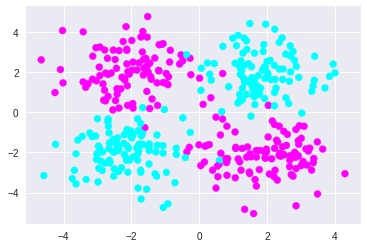

In [281]:
nb_samples=400
samples=np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2+noise[0],-2+noise[1]), 0
    samples[i+1] = (2+noise[2],-2+noise[3]), 1
    samples[i+2] = (-2+noise[4],2+noise[5]), 1
    samples[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:], cmap=plt.cm.cool)

Model:  (2, 16, 1)


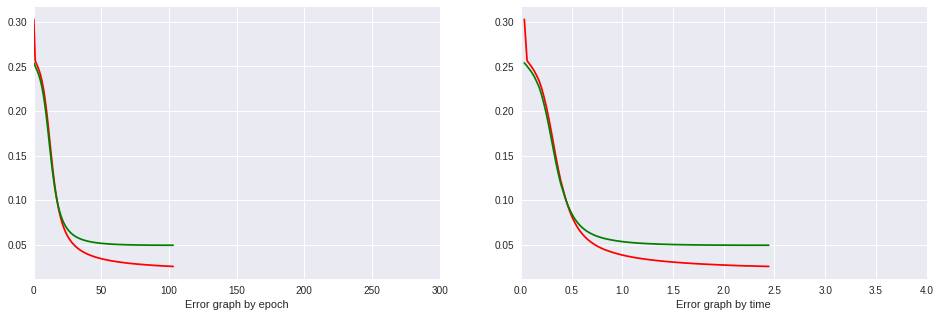

Epoch: 103 - Train error: 0.025677 - Test error: 0.031210 - Learn time: 2.444237


In [294]:
network = MLP(2,16,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 10, 1)


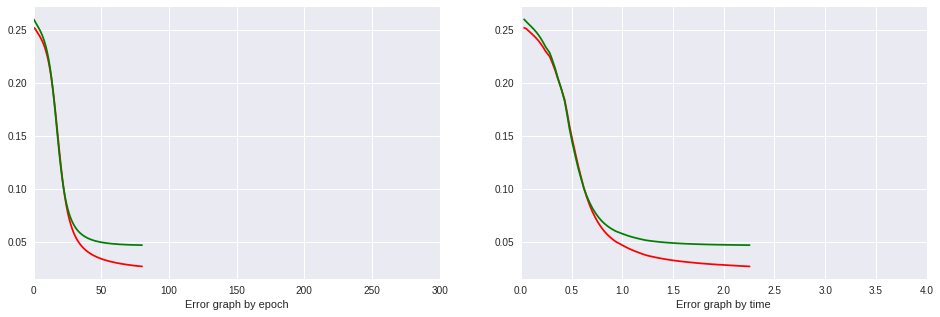

Epoch: 80 - Train error: 0.027004 - Test error: 0.039615 - Learn time: 2.255332


In [295]:
network = MLP(2,10,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 7, 1)


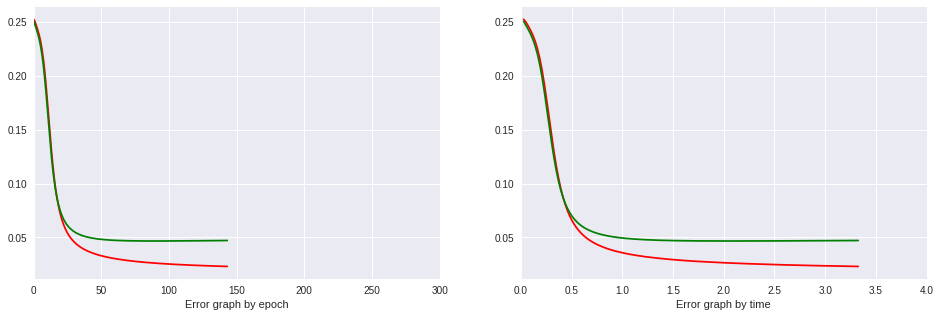

Epoch: 143 - Train error: 0.023029 - Test error: 0.033630 - Learn time: 3.325788


In [297]:
network = MLP(2,7,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

lrate0.025000
Model:  (2, 7, 1)


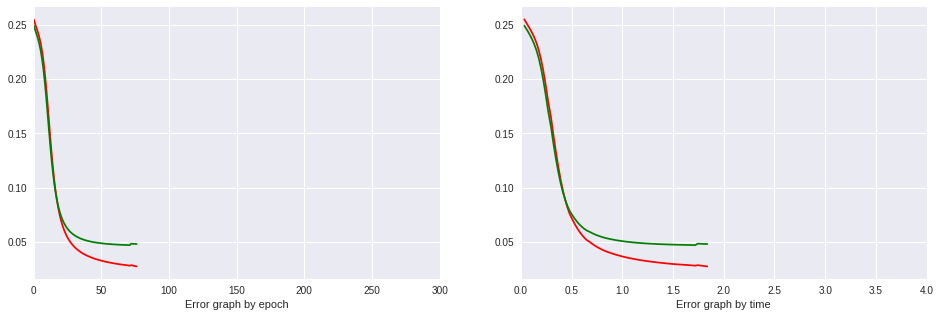

Epoch: 76 - Train error: 0.027567 - Test error: 0.032064 - Learn time: 1.837752


In [317]:
network = MLP(2,7,1)
np.random.seed(0)
network.reset()
learn_double_lr(network, samples, 0.2, 0.1)

Model:  (2, 5, 1)


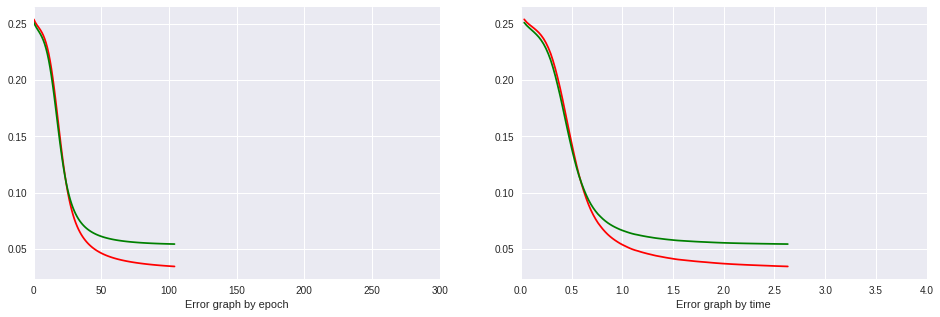

Epoch: 104 - Train error: 0.034184 - Test error: 0.051155 - Learn time: 2.631558


In [298]:
network = MLP(2,5,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 2, 1)


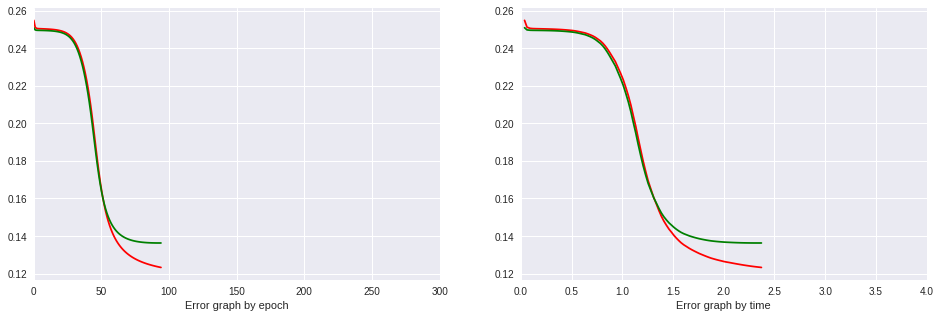

Epoch: 94 - Train error: 0.123253 - Test error: 0.097226 - Learn time: 2.371606


In [299]:
network = MLP(2,2,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 16, 16, 1)


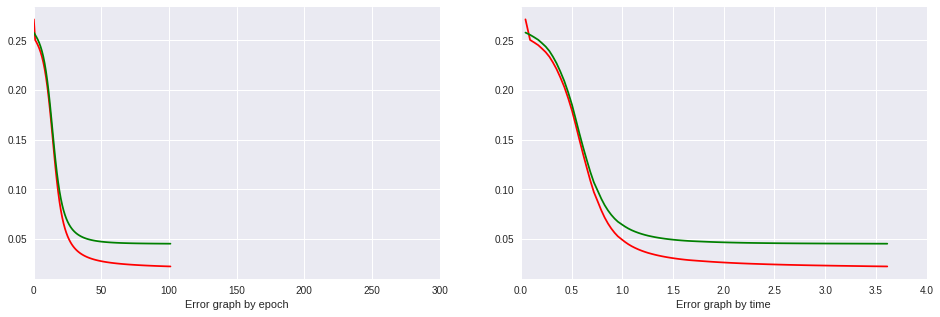

Epoch: 101 - Train error: 0.022502 - Test error: 0.036271 - Learn time: 3.612110


In [300]:
network = MLP(2,16,16,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 16, 10, 1)


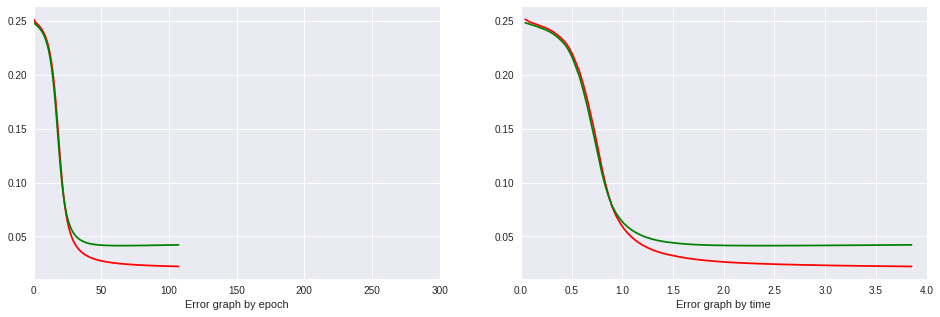

Epoch: 107 - Train error: 0.022201 - Test error: 0.044023 - Learn time: 3.851701


In [301]:
network = MLP(2,16,10,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 16, 7, 1)


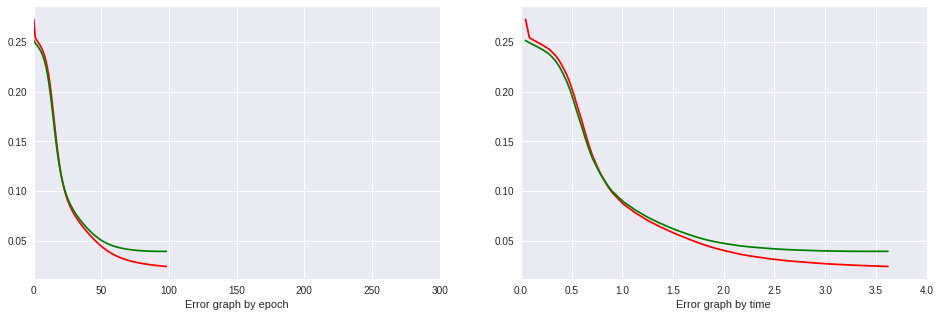

Epoch: 98 - Train error: 0.024159 - Test error: 0.044908 - Learn time: 3.618716


In [302]:
network = MLP(2,16,7,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 16, 4, 1)


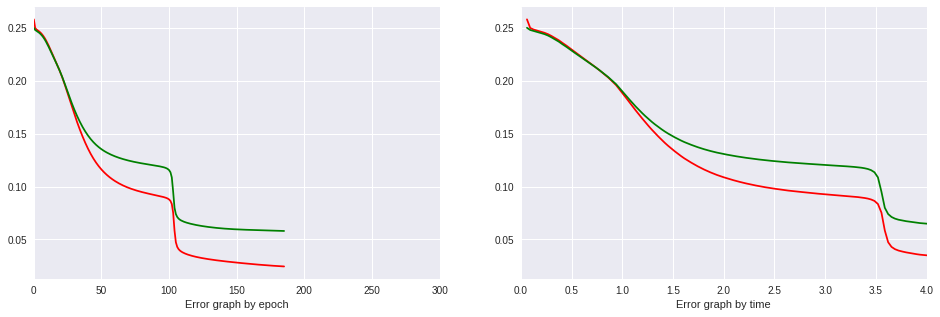

Epoch: 185 - Train error: 0.024488 - Test error: 0.028989 - Learn time: 6.381145


In [303]:
network = MLP(2,16,4,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)

Model:  (2, 16, 2, 1)


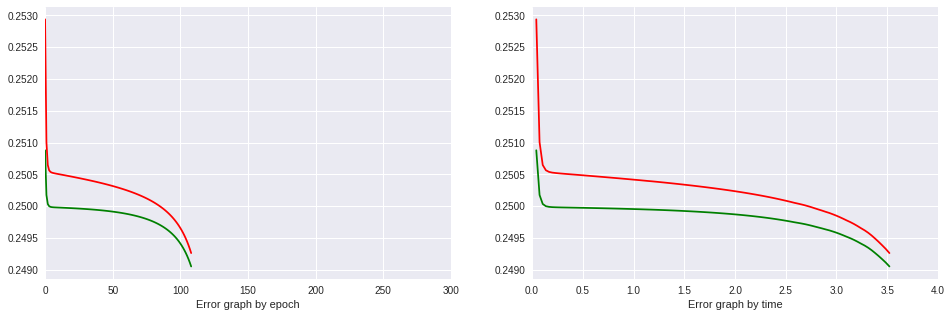

Epoch: 108 - Train error: 0.249263 - Test error: 0.249145 - Learn time: 3.522509


In [305]:
network = MLP(2,16,2,1)
np.random.seed(0)
network.reset()
learn(network, samples, 0.2, 0.1)